In [79]:
import pandas as pd
import inflection
import numpy as np

from IPython.core.display import HTML
from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats


**Helper Function**



In [82]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(cm)[0]
    n = cm.sum().sum()
    r, k = cm.shape
    phi = chi2/n
    phibiascorrect = max(0, phi - (k-1)*(r-1)/(n-1))
    k_denominator = k - (k-1)**2 / (n-1)
    r_denominator = r - (r-1)**2 / (n-1) 
    denominator = min(k_denominator-1, r_denominator-1)
    return np.sqrt(phibiascorrect / denominator)


In [3]:
df_sales_raw = pd.read_csv('/home/jan/logos_stores/data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/home/jan/logos_stores/data/raw/store.csv', low_memory=False)

#merge dos dataframe
data_merge = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# Descrição dos dados



In [5]:
df1_copy = data_merge.copy()
df1_copy.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## Renomeando colunas




In [6]:
colunas = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
        'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
        'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase        = lambda x: inflection.underscore(x)
cols_new         = list(map(snakecase, colunas))
df1_copy.columns = cols_new




In [7]:
# ---> Data dimensions <--- 
print(f'Number of rows {df1_copy.shape[0]}')
print(f'Number of cols {df1_copy.shape[1]}')

Number of rows 1017209
Number of cols 18


In [8]:
df1_copy.date = pd.to_datetime(df1_copy.date)
df1_copy.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NA




In [9]:
df1_copy.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### **Existem 3 maneira de tratar NA**

- > Excluir. Excluir os valores nulos é uma maneira de "trata-los,contudo, "livrar-se do problema não significa resolve-lo" dados faltantes podem prejudicar algum tipo de análise ou predição. Isso se dá porque estamos 'jogando dados fora'.


- > Usar algoritimos de ML. A utilização de determinado algoritmo vai estimar o valor que estaria ali naquela posição tomando como base o comportamento dos dados da coluna. 


- > E a 3 forma, e que talvez a que eu considere a mais sensata, **é entender o porquê aquele dado esta faltando.**



### Fillout NA



In [10]:
import math
df1_copy['competition_open_since_year']

0          2008.0
1          2007.0
2          2006.0
3          2009.0
4          2015.0
            ...  
1017204    2014.0
1017205    2006.0
1017206       NaN
1017207       NaN
1017208       NaN
Name: competition_open_since_year, Length: 1017209, dtype: float64

In [11]:
#CompetitionDistance 
df1_copy['competition_distance'] = df1_copy['competition_distance'].apply(lambda x: 200000 if pd.isnull(x) else x)

#CompetitionOpenSinceMonth
df1_copy['competition_open_since_month'] = df1_copy.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#CompetitionOpenSinceYear 
df1_copy['competition_open_since_year'] = df1_copy.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


#Promo2SinceWeek 
df1_copy['promo2_since_week'] = df1_copy.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#Promo2SinceYear
df1_copy['promo2_since_year'] = df1_copy.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)






In [12]:
df1_copy.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year                    0
promo_interval                  508031
dtype: int64

In [13]:
#PromoInterval
month_map = {1: 'Jan', 2: 'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1_copy.fillna(0, inplace=True)

df1_copy['month_map']  = df1_copy['date'].dt.month.map(month_map)

df1_copy['is_promo']   = df1_copy[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'] else 0, axis=1)


In [14]:
df1_copy.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
369570,502,1,2014-08-11,9772,1379,1,0,0,1,a,a,220.0,2.0,2002.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct",Aug,0


## Change Types

### 1.6. DESCRIÇÃO DOS DADOS



In [15]:
df1_copy.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1_copy['competition_open_since_month'] = df1_copy['competition_open_since_month'].astype( int )
df1_copy['competition_open_since_year'] = df1_copy['competition_open_since_year'].astype( int )
df1_copy['promo2_since_week'] = df1_copy['promo2_since_week'].astype( int )
df1_copy['promo2_since_year'] = df1_copy['promo2_since_year'].astype( int )

## . DESCRIÇÃO DOS DADOS



In [17]:
#Para facilitar o tratamento das nossas variáveis, vamos criar algumas variaveis auxiliares. 
num_attributes = df1_copy.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1_copy.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])



In [18]:
#Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#DIspersion - STD, MIN, MAX, RANGE, SKEW, KURTOSIS
d1  = pd.DataFrame(num_attributes.apply( np.std )).T
d2  = pd.DataFrame(num_attributes.apply( min )).T
d3  = pd.DataFrame(num_attributes.apply( max )).T
d4  = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5  = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6  = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T
#----------------------------------------------------------------------

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/home/jan/miniconda3/envs/ds_prod/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


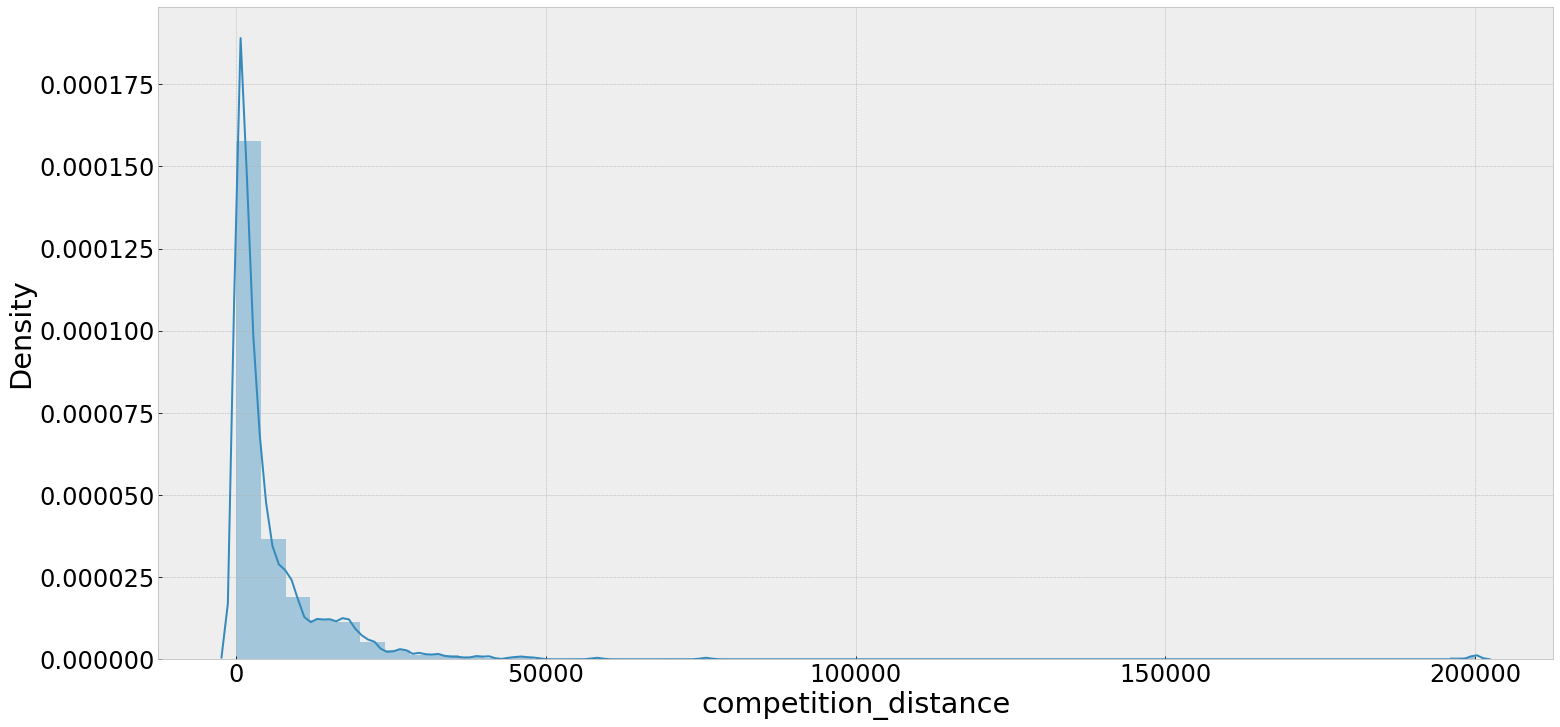

In [19]:
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 12]
plt.rcParams['font.size'] = 24

sns.distplot(df1_copy['competition_distance']);

# Categorical Attributes




In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

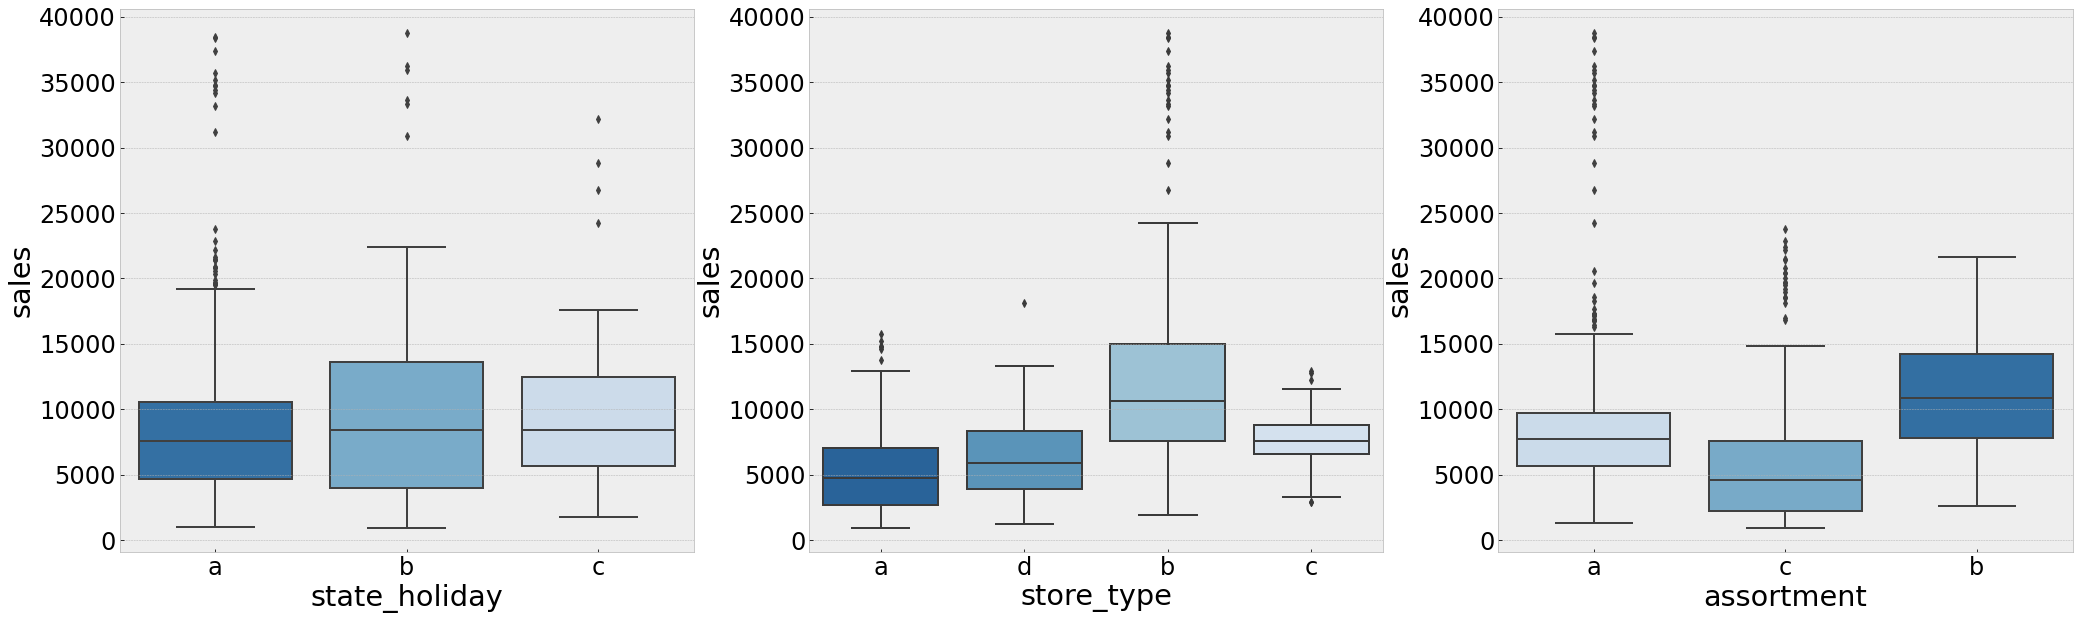

In [23]:

filter_0 = df1_copy[(df1_copy.state_holiday != '0') & (df1_copy.sales > 0)]
plt.figure(figsize=[35,10])

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=filter_0, palette='Blues_r');

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=filter_0, palette='Blues_r');

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=filter_0, palette='Blues');

plt.save()

 <font color='Blue'>-----------------------------------------------------------------------------------</font>

# Features Engineering - Adianto esse passo pra facilitar a EDA :D

#### Mapa mental de hipóteses

In [24]:
Image("/home/jan/ds_em_producao/img/DSL_-_Daily_Store_Sales_warning.png")

FileNotFoundError: No such file or directory: '/home/jan/ds_em_producao/img/DSL_-_Daily_Store_Sales_warning.png'

FileNotFoundError: No such file or directory: '/home/jan/ds_em_producao/img/DSL_-_Daily_Store_Sales_warning.png'

<IPython.core.display.Image object>

## CH - Criação das hipóteses

###  2.1.1 Hipoteses loja

**1** Lojas com número maior de fucionários deveriam vender mais

**2** Lojas com maior capacidade de estoque deveriam vender mais

**3** Lojas com maior porte deveriam vender mais

**4** Lojas com maior sortimento deveriam vender mais 

**5** Lojas com competidores mais proximos deveriam vender menos

**6** LOjas com competidores  mais tempo deveriam vender mais 

### 2.1.2 Hipoteses Produto

**1** Lojas que investem mais em Marketing deveriam vender mais

**2** Lojas com maior exposição do produto deveriam vender mais.

**3** Lojas com produtos com preço menor deveriam vender mais

**4** Lojas com promoções mais agressivas (Descontos maiores) deveriam vender mais

**5** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6** Lojas com mais dias de promoção deveriam vender mais 

**7** Lojas com mais promoções consecutivas deveriam vender mais 


### 2.1.3 Hipoteses Tempo

**1** Lojas abertas durante o feriado de natl deveriam vender mais

**2** Lojas deveriam vender mais ao longo dos anos

**3** Lojas deveriam vender mais no segundo semestre do ano.

**4** Lojas deveriam vender mais depois do dia 10 de cada mês

**5** Lojas deveriam vender menos aos finais de semana

**6** Lojas deveriam vender menos durante os feriados escolares

### 2.1.4 Hipoteses finais 

#### loja
**1** Lojas com maior sortimento deveriam vender mais 

**2** Lojas com competidores mais proximos deveriam vender menos

**3** LOjas com competidores  mais tempo deveriam vender mais



#### produto
**4** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5** Lojas com mais dias de promoção deveriam vender mais 

**6** Lojas com mais promoções consecutivas deveriam vender mais 

#### tempo
**7** Lojas abertas durante o feriado de natl deveriam vender mais

**8** Lojas deveriam vender mais ao longo dos anos

**9** Lojas deveriam vender mais no segundo semestre do ano.

**10** Lojas deveriam vender mais depois do dia 10 de cada mês

**11** Lojas deveriam vender menos aos finais de semana

**12** Lojas deveriam vender menos durante os feriados escolares


*As hipóteses finais são aquelas que foram priorizadas de acordo com os dados que 
tenho disponivel no meu dataframe.*

### Derivando as variáveis que serão utilizadas EDA

In [25]:
df2 = df1_copy

In [26]:
df2.state_holiday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [27]:
import datetime

In [28]:
#year
df2['year'] = df2['date'].dt.year
#Month
df2['month'] = df2['date'].dt.month
#Day
df2['day'] = df2['date'].dt.day
#Week of Year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
#Year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

#Competition since
df2.competition_open_since_year =  df2.competition_open_since_year.astype(int)
df2.competition_open_since_month =  df2.competition_open_since_month.astype(int)
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                                                 month=x['competition_open_since_month'], 
                                                                 day=1), axis=1)

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) /30 ).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )


#assortment

df2 ['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
#state holiday 

df2 ['state_holiday'] = df2['state_holiday'].apply(lambda x: 'Public holiday' if x == 'a' else 'Easter holiday' if x == 'b' else 'Christmas' if x == 'c' else 'Regular day')


In [29]:
df2.competition_open_since_month

0           9
1          11
2          12
3           9
4           4
           ..
1017204     6
1017205     4
1017206     1
1017207     1
1017208     1
Name: competition_open_since_month, Length: 1017209, dtype: int64

#  filtragem x seleção de variaveis, qual a diferença?


## filtrar variável



In [30]:
df3 = df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,Regular day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,Regular day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,Regular day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,Regular day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,Regular day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## filtragem das linhas


In [31]:
#Restrições
df3 = df3 [(df3['open'] != 0) & (df3['sales'] > 0)]

## Seleção de colunas

In [32]:
cols_drop = ['month_map','promo_interval', 'customers', 'open']
df3 = df3.drop(cols_drop, axis=1)

In [33]:
df3.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_week                               object
competition_s

<font color='Blue'> ----------------------------------------------------------------------------------- </font>

# Analise exploratória dos dados.

- > **Como as variáveis impactam o fênomeno e qual a força desse impacto?**




## Análise univariada



In [34]:
#response variable
df4 = df3.copy()

#df3.to_csv('../data/df4.1.csv')

/home/jan/miniconda3/envs/ds_prod/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


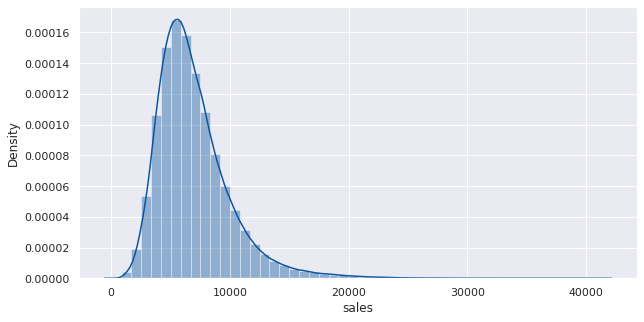

In [35]:

plt.figure(figsize=[10,5])
sns.set_theme(palette='Blues_r')
sns.distplot(df4.sales)
plt.savefig('../img/univariate_numerical', bbox_inches='tight')

### Numerical variable - Distribuições gerais

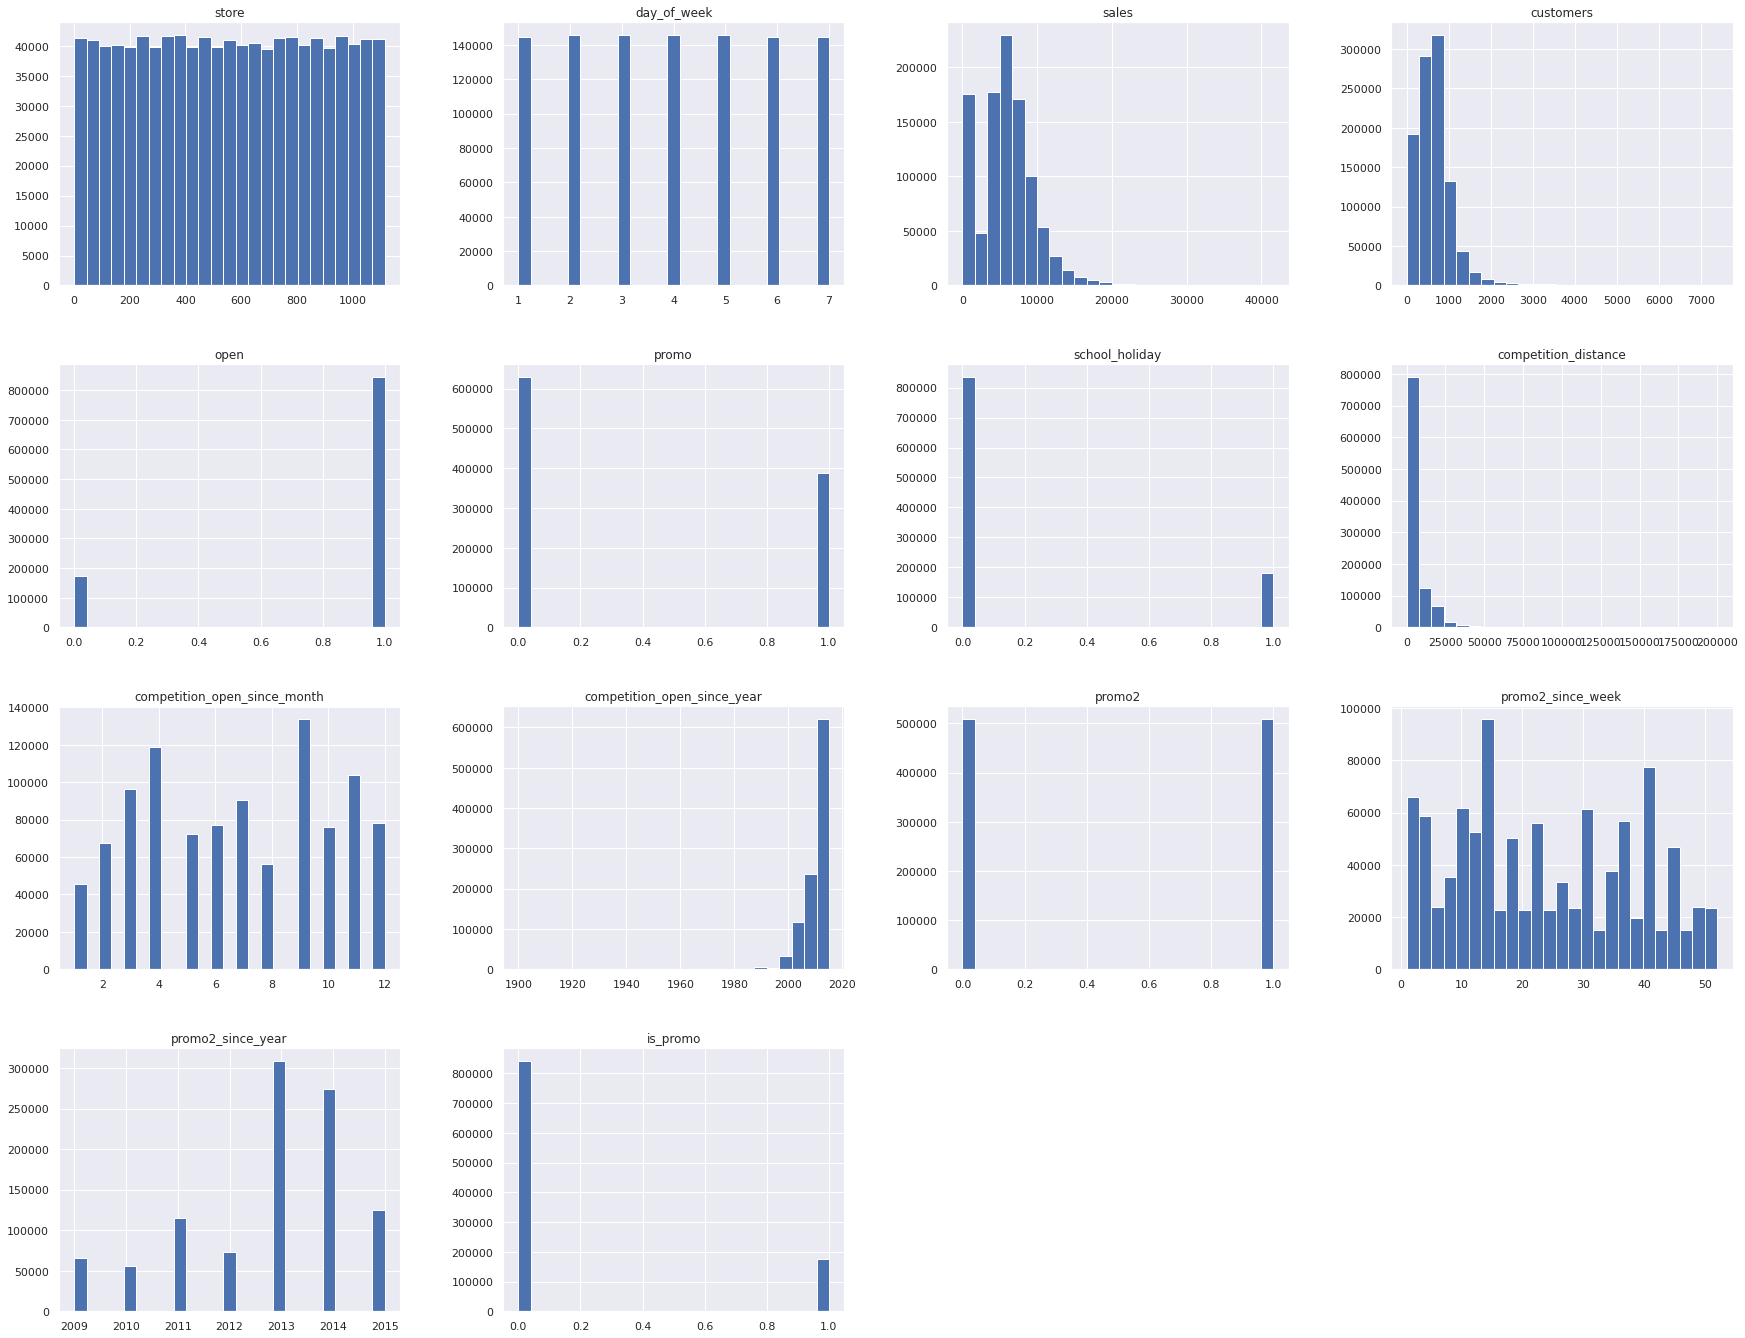

In [36]:
sns.set_theme()
num_attributes.hist(bins=25, figsize= [30,30], layout=[5,4] );
plt.savefig('../img/univariate_numerical_1.1.png', dpi=300, bbox_inches='tight')


### Qual tipo de feriado vende mais? 

In [37]:
df4.state_holiday.drop_duplicates()

0            Regular day
63559     Public holiday
129424    Easter holiday
241126         Christmas
Name: state_holiday, dtype: object

In [38]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_week                               object
competition_s

/home/jan/miniconda3/envs/ds_prod/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jan/miniconda3/envs/ds_prod/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jan/miniconda3/envs/ds_prod/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

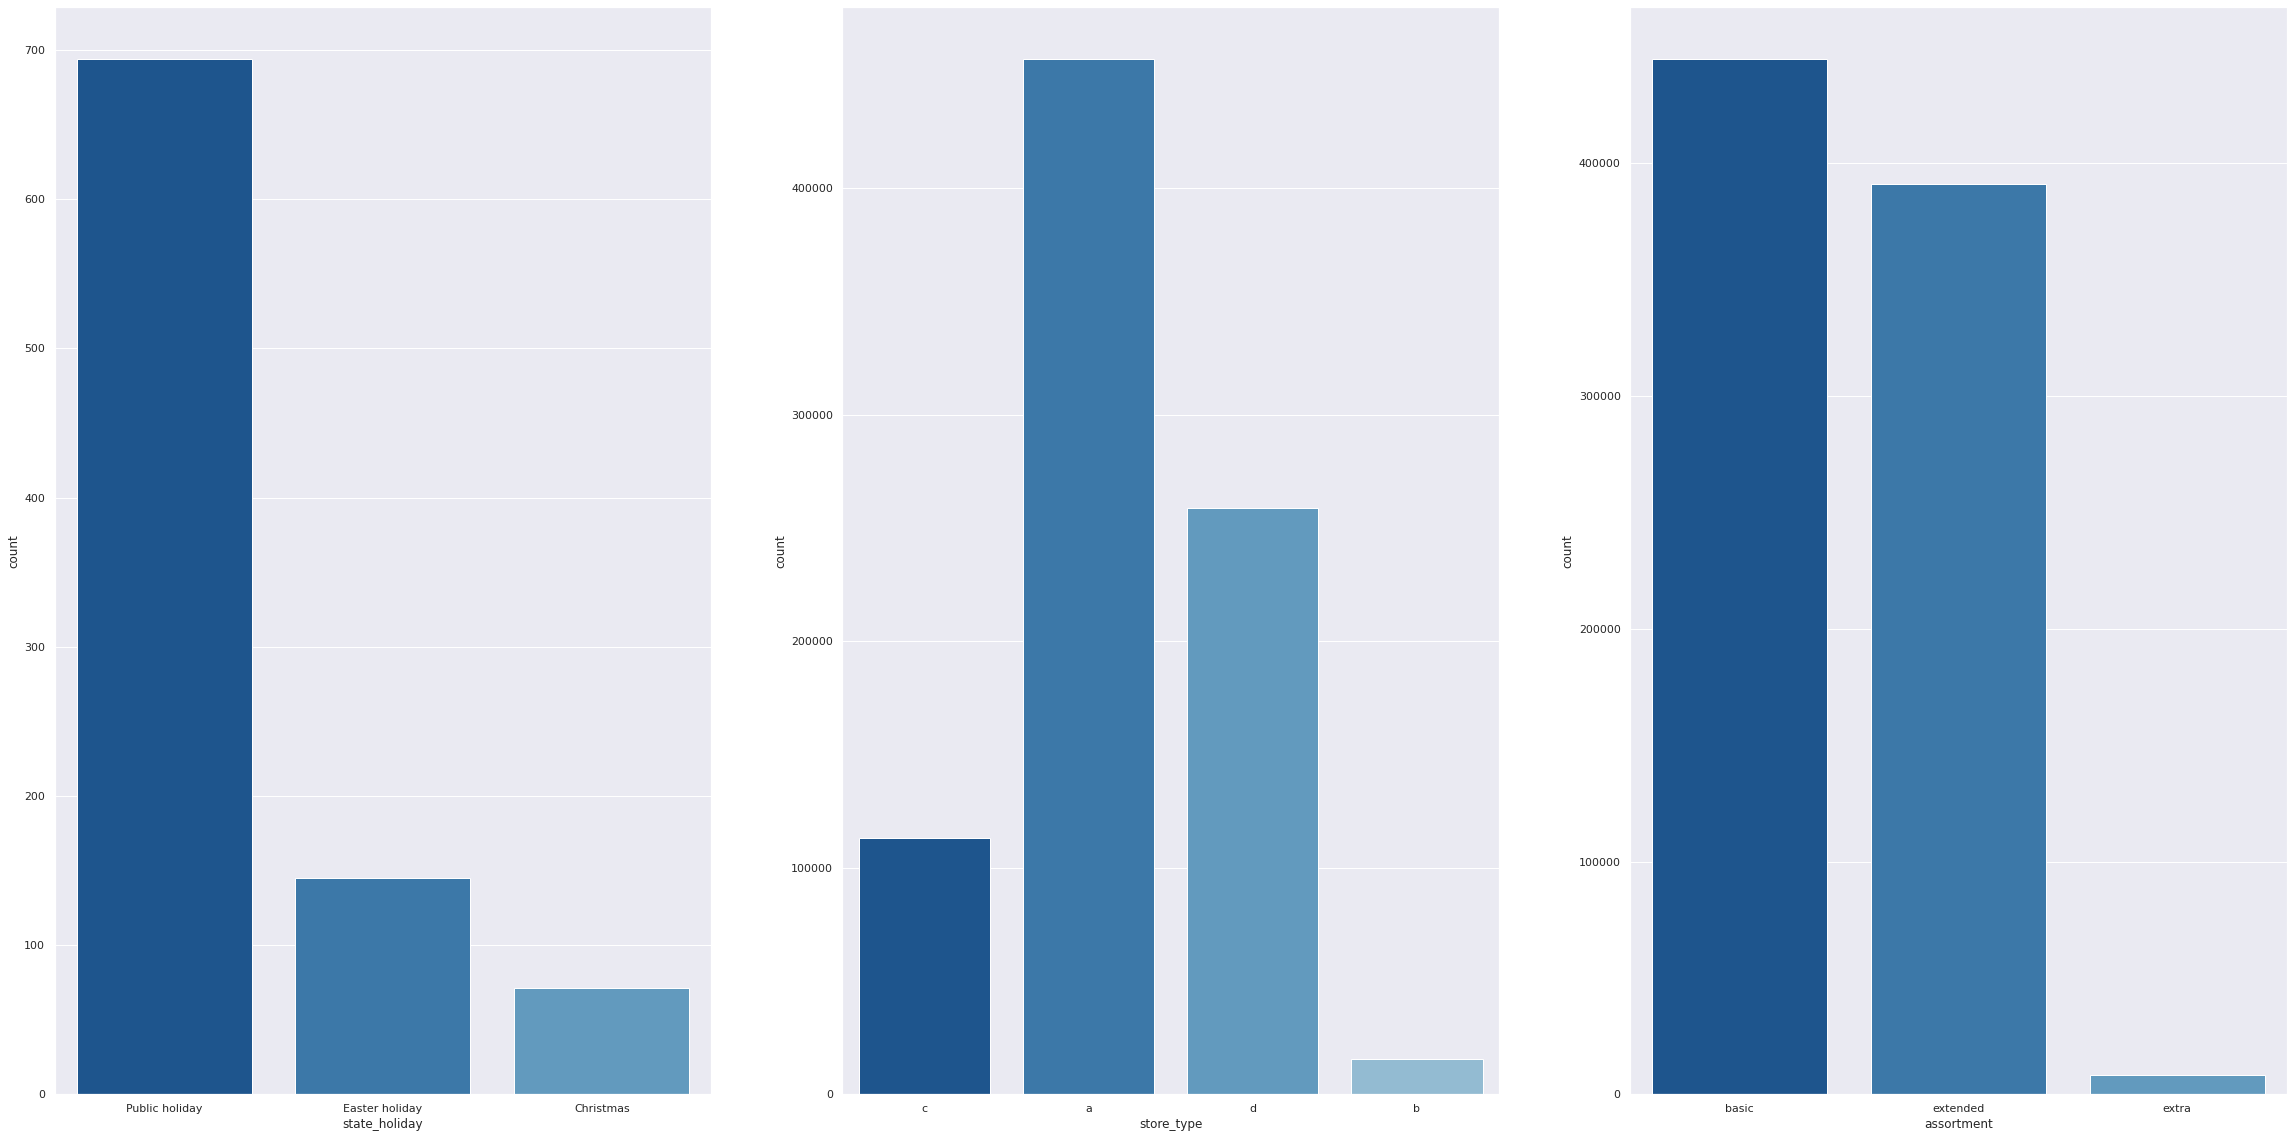

In [39]:
a = df4[df4['state_holiday'] != "Regular day"]




sns.set_theme(palette='Blues_r')

#state_holiday
plt.figure(figsize=[40,20])
plt.subplot(1,3,1)
sns.countplot(a.state_holiday);

'''plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'Public holiday']['sales'], label='public_holiday', shade='True')
sns.kdeplot(df4[df4['state_holiday'] == 'Easter holiday']['sales'], label='Easter_holiday', shade='True')
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade='True')'''
#store_type
plt.subplot(1,3,2)
sns.countplot(df4.store_type);


'''plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)'''

#assortment

plt.subplot(1,3, 3)
sns.countplot(df4.assortment);


'''plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)'''
plt.savefig('../img/univariate_categorical_1.png', dpi=300)

    








## Analise Bivariada

### H1 - > Lojas com mais promoções consecutivas vendem mais - <span class="mark">*False*</span> 
- > *Lojas com mais promoções consecutivas vendem menos.*

In [40]:
#Analisando para saber se as lojas que participaram da promoção extendida venderam mais.
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

#Sera que esse comportamento mudou ao longo do tempo?




,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


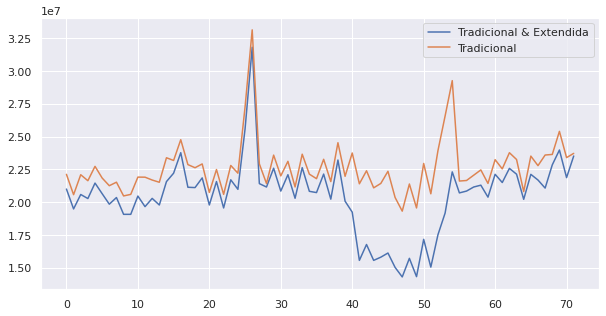

In [41]:
aux1 = df4[( df4['promo'] == 1) & (df4['promo2'] == 1) ][[ 'year_week', 'sales' ]].groupby('year_week').sum().reset_index()
aux2 = df4[( df4['promo'] == 1) & (df4['promo2'] == 0) ][[ 'year_week', 'sales' ]].groupby('year_week').sum().reset_index()


sns.set_theme()
ax = aux1.plot(figsize=[10,5]);
aux2.plot(ax=ax);
ax.legend(labels=['Tradicional & Extendida', 'Tradicional'])
plt.savefig('../img/h1_1.png', dpi=300, bbox_inches='tight')


### H2 - Lojas abertas durante o feriado de natal deveriam vender mais - > <span class="mark">*False*</span>. 

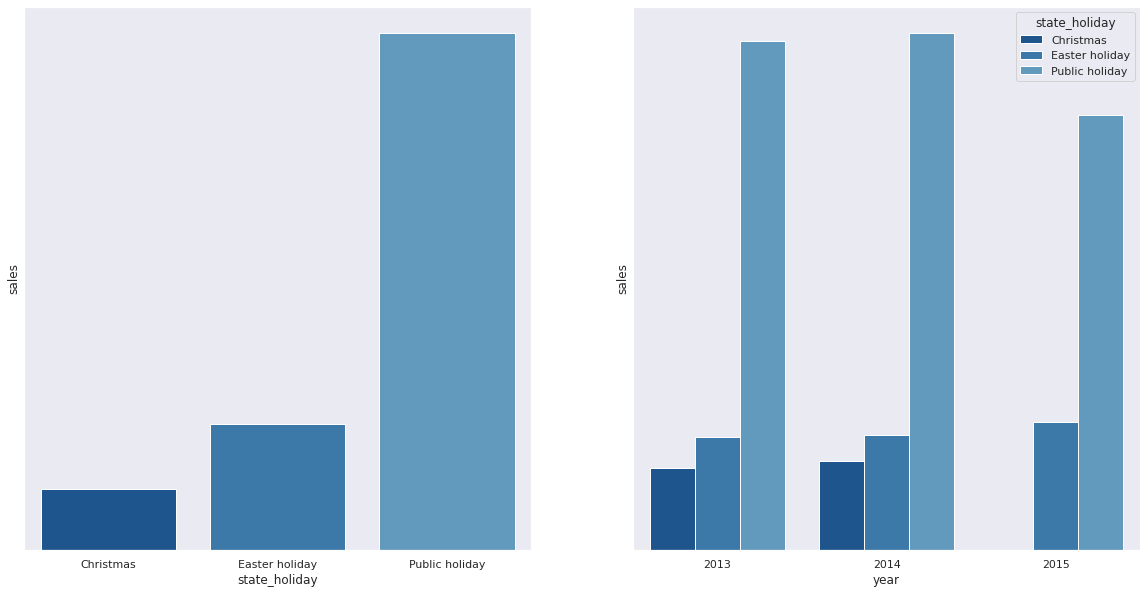

In [42]:
aux = df4[ df4['state_holiday'] != 'Regular day' ]
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()


sns.set_theme(palette='Blues_r')
plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
sns.barplot(x='state_holiday', y='sales', data=aux1);
plt.yticks([],[])

#Em algum momento, o feriado teve mais vendas. 

plt.subplot(1,2,2)

aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales',hue='state_holiday', data=aux2);
plt.yticks([],[])
plt.savefig('../img/h2',dpi=300,bbox_inches='tight')


### H3 - > lojas deveriam vender mais ao longo dos anos - > <span class="mark">*Falso*</span> 
- > Lojas vendem menos ao longos dos anos. 

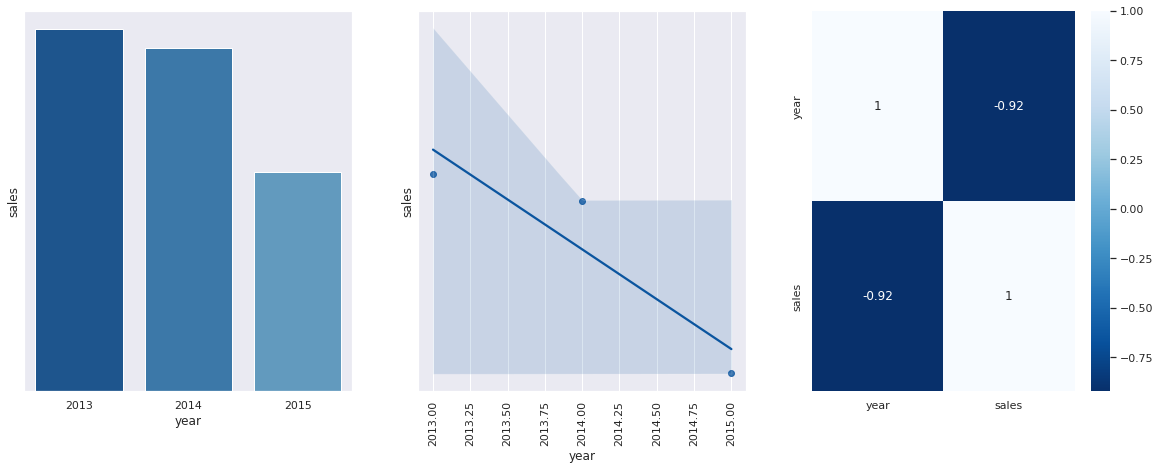

In [43]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.figure(figsize=[20, 7])

sns.set_theme(palette='Blues_r')
#plot de comparação por barras.
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);
plt.yticks([], [])
#plot tendência.
plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);
plt.yticks([], [])
plt.xticks(rotation=90)

#Entendimento da importancia para o aprendizado.
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='Blues_r');
plt.savefig('../img/h3_3', dpi=300, bbox_inches='tight' )


### H4 -> lojas deveriam vender mais no segundo semestre - > <span class="mark">*False*</span>

- > **A hipótese é falsa, as vendas na verdade diminuem no segundo semestre do ano.**


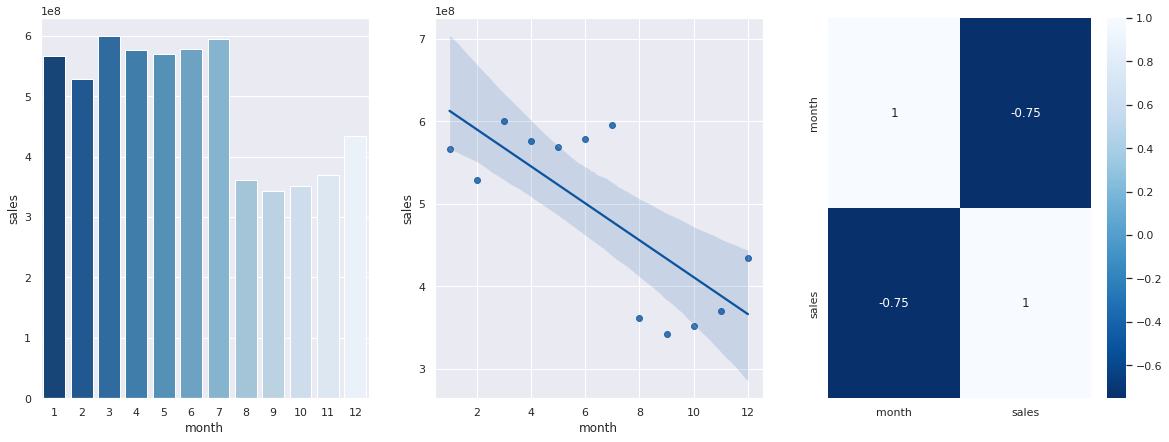

In [44]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1, palette='Blues_r')

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, data=aux1, cmap='Blues_r');
#plt.savefig('../img/h4', bbox_inches='tight' )


### H6 - > Lojas com maior sortimento (*assortment*) deveriam vender mais. - <span class="mark">False.</span>
 - > *Lojas com maior assortment vendem menos* mais promoções consecutivas vendem menos.*

Text(0, 0.5, 'sales')

<Figure size 1800x864 with 0 Axes>

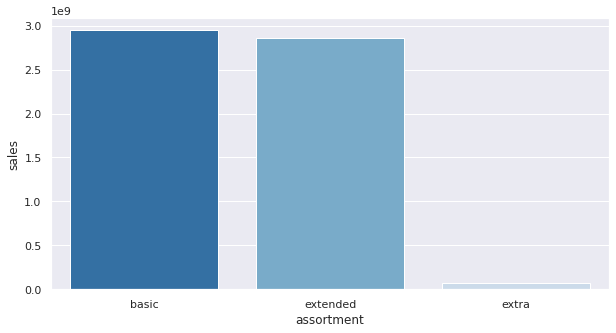

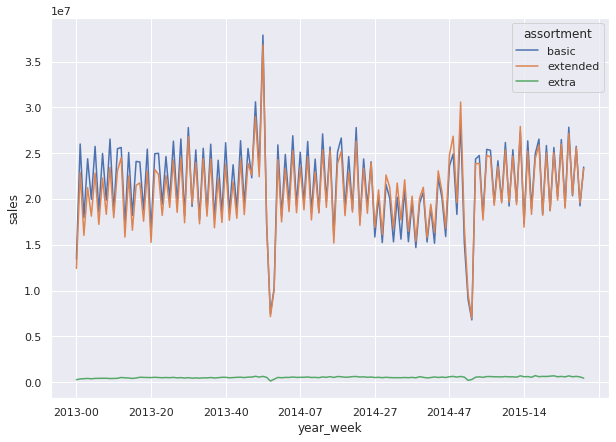

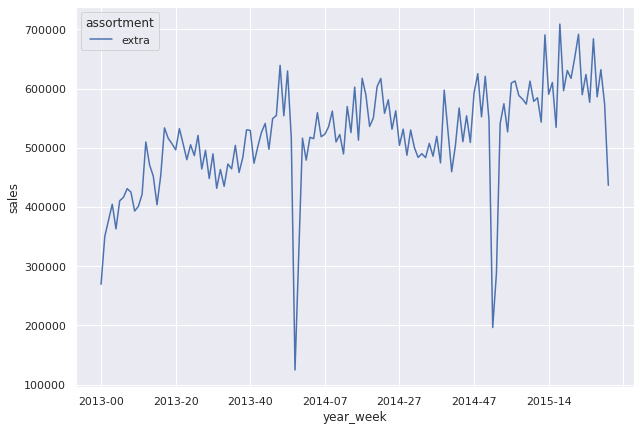

In [45]:
plt.figure()
plt.figure(figsize=[10,5])
sns.set_theme()
#plot1

aux1= df4[['assortment', 'sales']].groupby( 'assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, palette='Blues_r');


plt.savefig('../img/h6', dpi=100, bbox_inches='tight' )


#plot2
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(10, 7))
plt.ylabel('sales')
plt.savefig('../img/h6_1', dpi=300 ,bbox_inches='tight' )

#plot3
aux3= aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(10,7))
plt.ylabel('sales')





### H7 -  Lojas com competidores mais proximos vendem menos




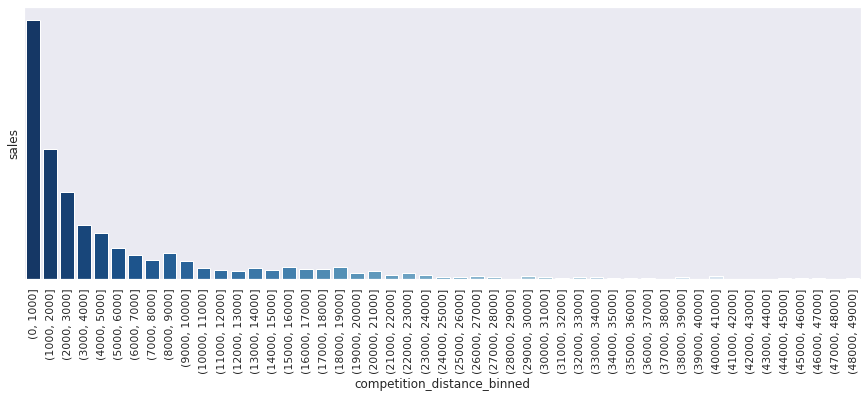

In [46]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
#sns.barplot(x='competition_distance', y='sales', data=aux1)

plt.figure(figsize=[15,5])
bins = list(np.arange(0, 50000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1.competition_distance, bins=bins)
aux2= aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x='competition_distance_binned', y='sales', data=aux2, palette='Blues_r')
plt.xticks( rotation=90);
plt.yticks([],[]);
#plt.savefig('../img/h7', dpi=300, bbox_inches='tight' )





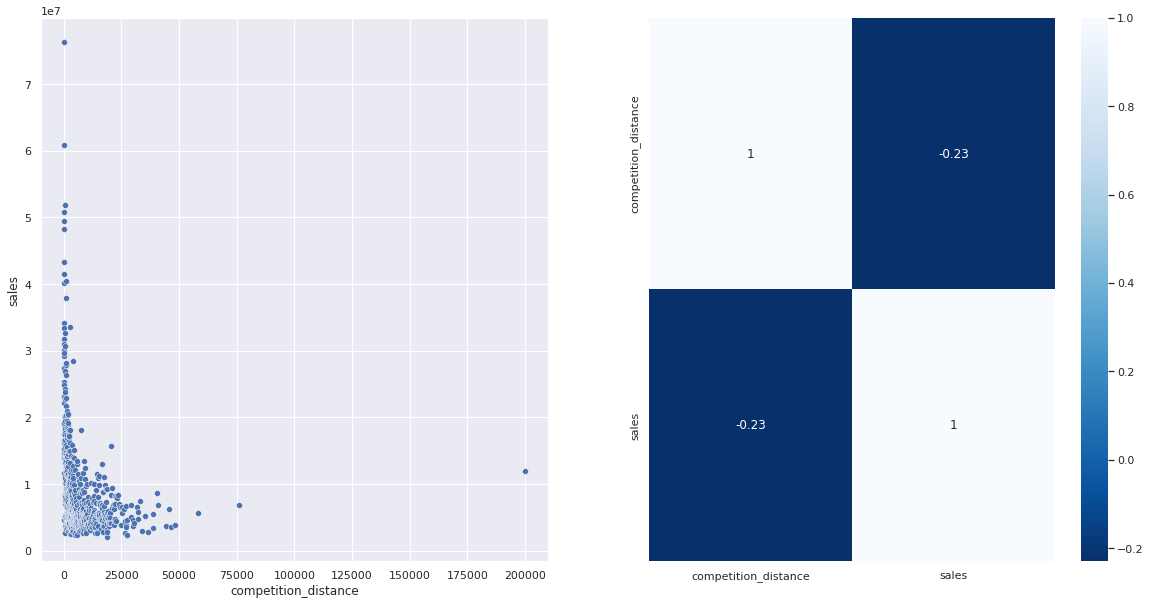

In [47]:
#Essa variavel vai ser importante pro modelo? 

plt.figure(figsize=[20,10])

plt.subplot(1,2,1)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x = aux1['competition_distance'], y=aux1['sales'])


#força da correlação competition distance e das vendas

plt.subplot(1,2,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='Blues_r')

plt.savefig('../img/h7_1', dpi=100, bbox_inches='tight' )







### H8 - > Lojas com competidores a mais tempo deveriam vender mais - <span class="mark">*False*</span>

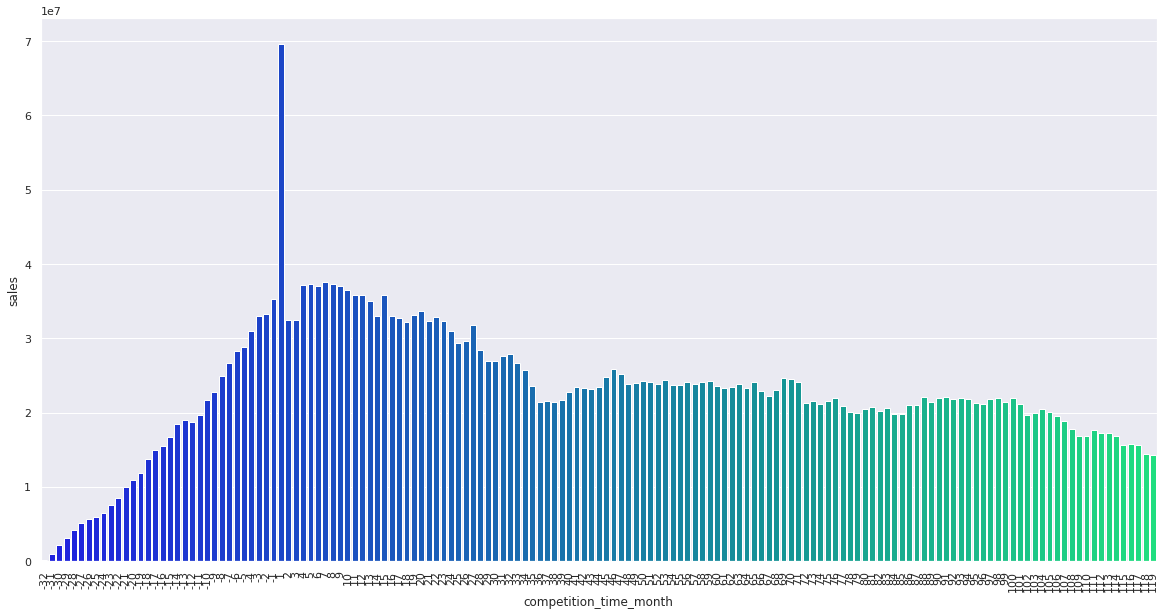

In [48]:


# tags -----> competition month, sales
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 ) ]

plt.figure(figsize=[20,10])

sns.barplot(x='competition_time_month', y='sales', data=aux2, palette='winter'); 
plt.xticks(rotation=90);

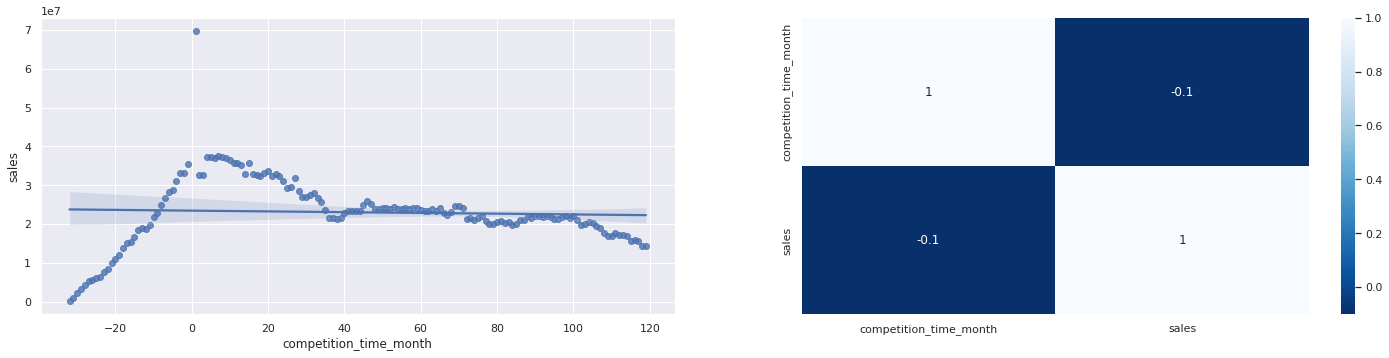

In [49]:
plt.subplot(2,2,1)
sns.regplot(x='competition_time_month', y='sales', data=aux2)


plt.subplot(2,2,2)

sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='Blues_r');
plt.savefig('../img/h8_1', dpi=100, bbox_inches='tight' )


### H9 - >  LOJAS COM PROMOÇÕES ATIVAS POR MAIS TEMPO DEVERIAM VENDER MAIS. - <span class="mark">*False*</span>

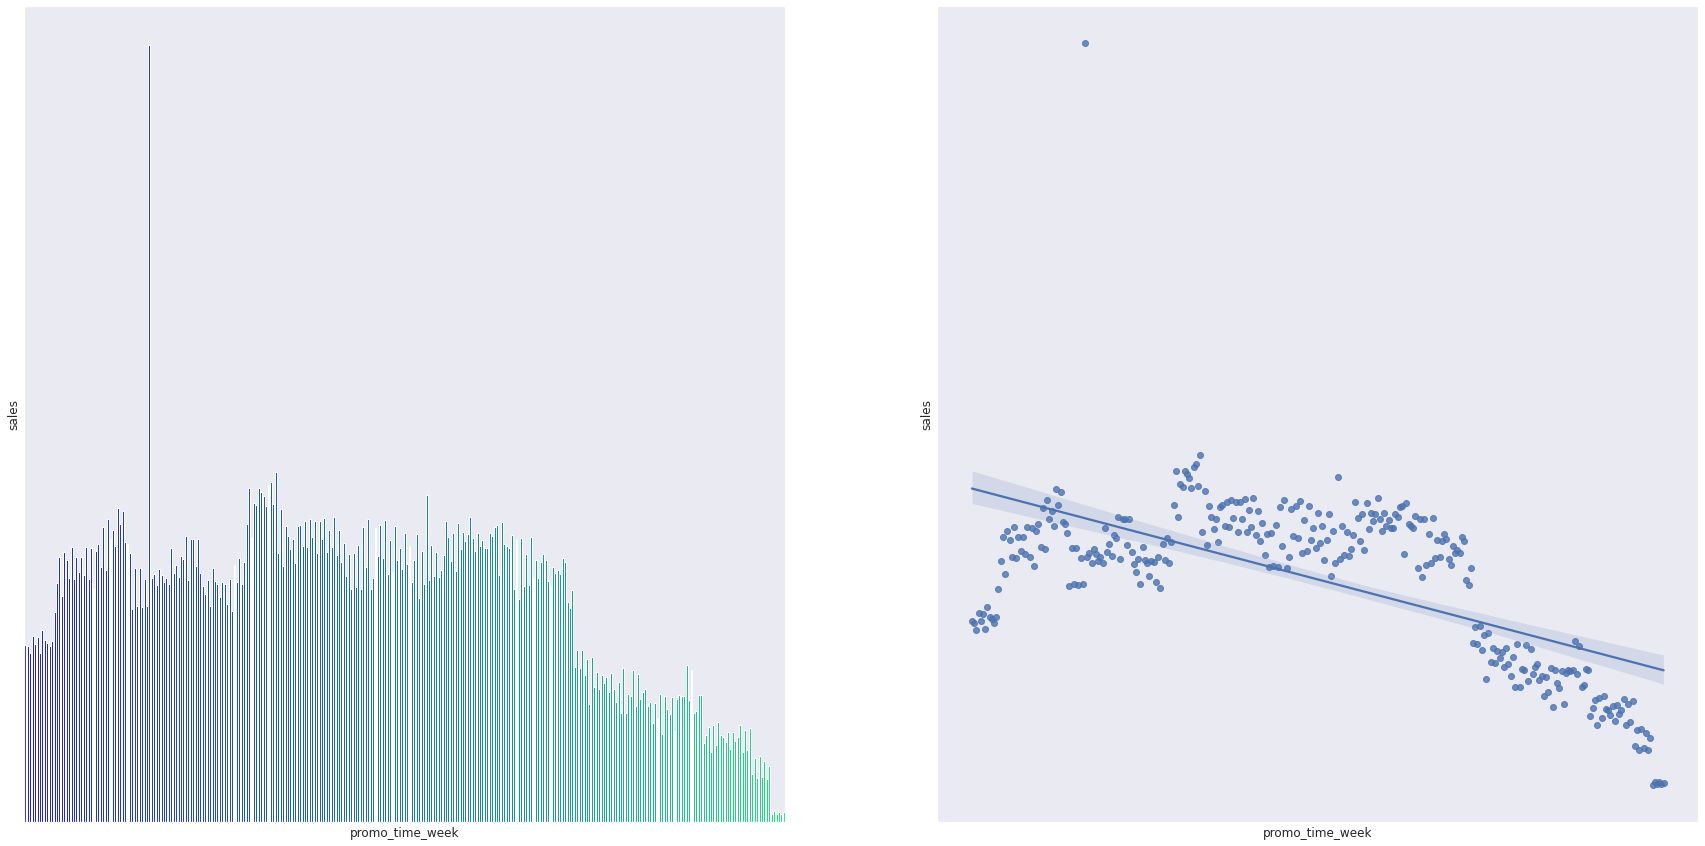

In [50]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
plt.figure(figsize=[30,15])

aux2 = aux1[ aux1[ 'promo_time_week' ] > 0 ]

plt.subplot(1,2,1)
sns.barplot( x='promo_time_week', y='sales', data=aux2, palette='winter');
plt.xticks([], []);
plt.yticks([], []);

plt.subplot(1,2,2)
sns.regplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks([], []);
plt.yticks([], []);

#plt.savefig('../img/h9', dpi=100, bbox_inches='tight' )




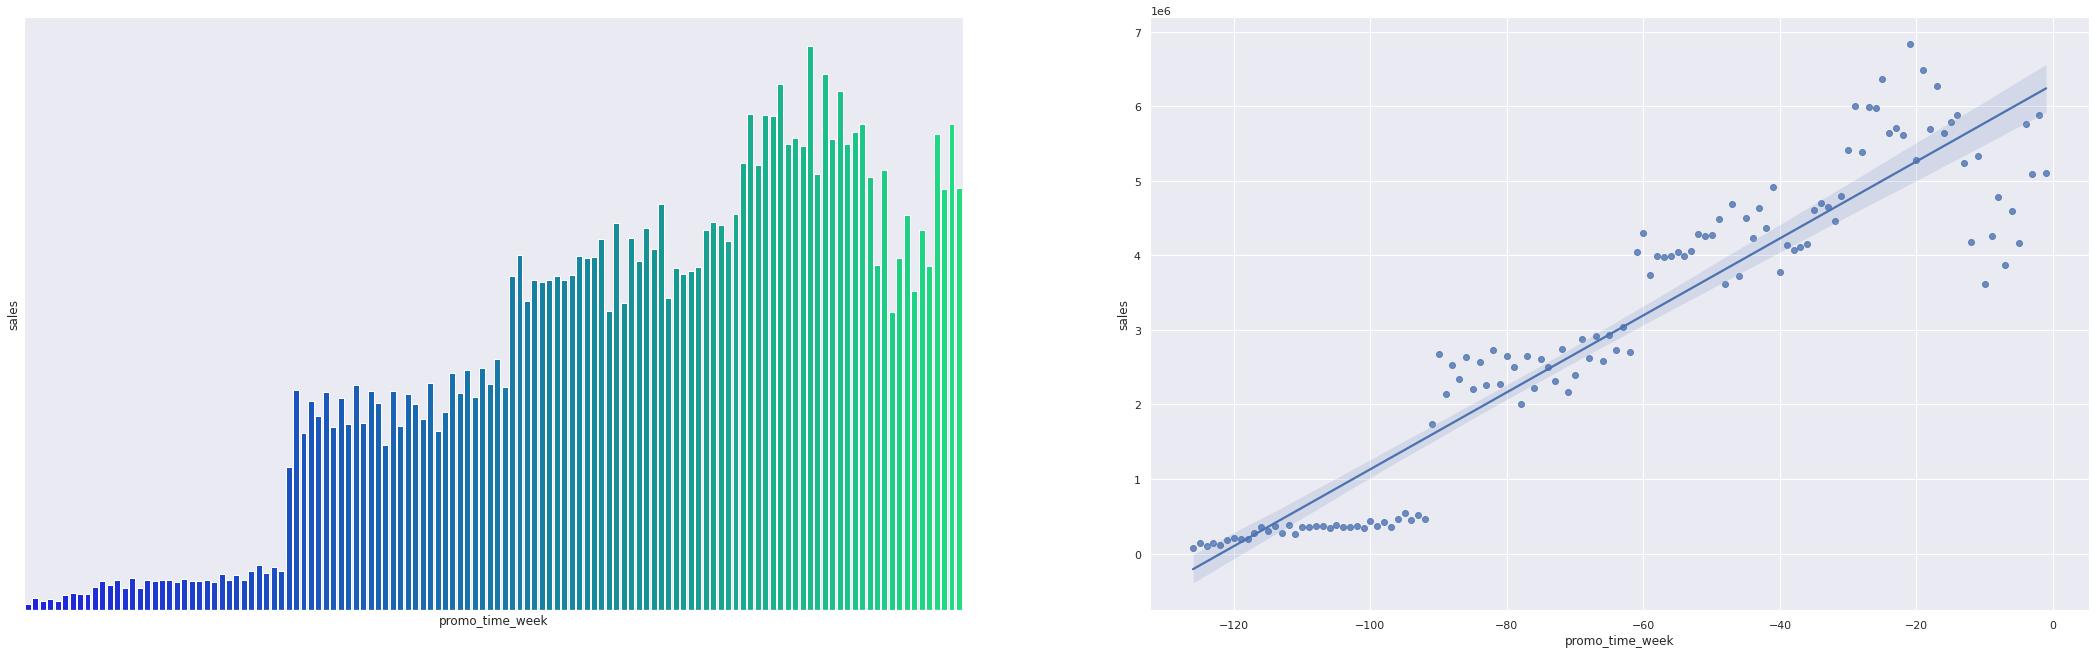

In [51]:
plt.figure(figsize=[37,24])

plt.subplot(2,2,3)
aux3 = aux1[aux1['promo_time_week'] < 0 ]
sns.barplot( x='promo_time_week', y='sales', data=aux3, palette='winter' );
plt.xticks([]);
plt.yticks([]);


plt.subplot(2,2,4)
sns.regplot( x='promo_time_week', y='sales', data=aux3 );




### H10 - Lojas deveriam vender menos durante os feriados escolares - > <span class="girk">*True*</span>
-  A hipotese é verdadeira exceto no mês 7. Provavelmente isso se dá por conta das férias escolares. 


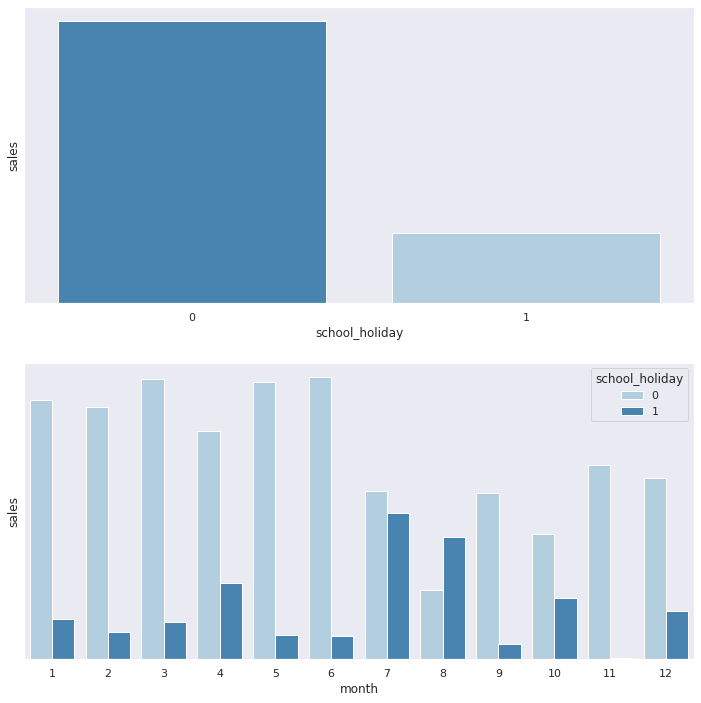

In [52]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.figure(figsize=(12, 12))
plt.subplot(211)
sns.barplot(x='school_holiday', y='sales', data=aux1, palette='Blues_r');
plt.yticks([], [])


plt.subplot(212)
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux2, palette='Blues');
plt.yticks([], [])

plt.savefig('../img/h10', dpi=100, bbox_inches='tight' )




### H11 -  Lojas deveriam vender menos aos finais de semana - > <span class="girk">*True*</span>


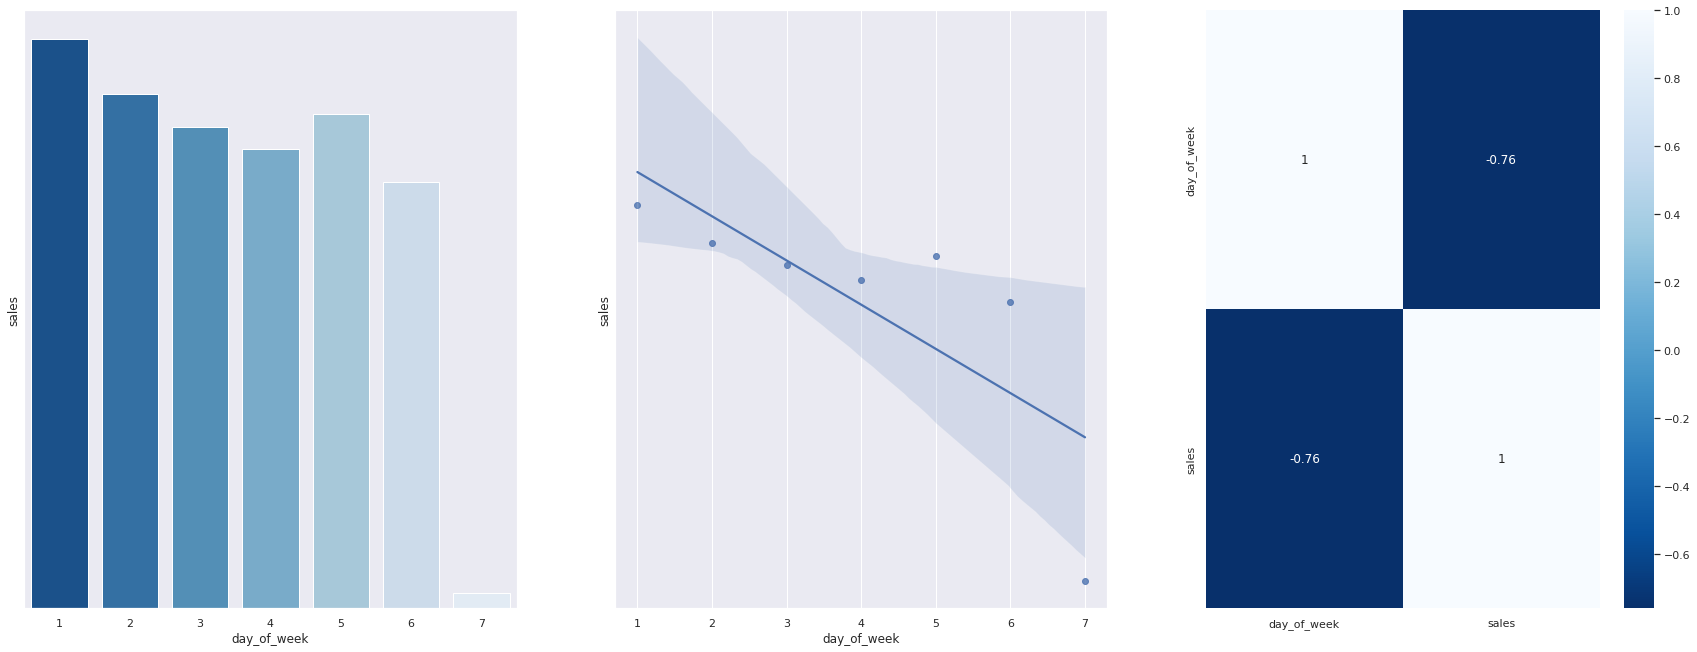

In [53]:
aux1 = df4[['day_of_week', 'sales']].groupby(['day_of_week']).sum().reset_index()

plt.figure(figsize=[30,11])
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1, palette='Blues_r');
plt.yticks([],[])

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);
plt.yticks([],[])

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, data=aux1, cmap='Blues_r');

plt.savefig('../img/h11', dpi=300, bbox_inches='tight' )


### H12 -  Lojas deveriam vender mais depois do dia 10 - > <span class="girk">*True*</span>


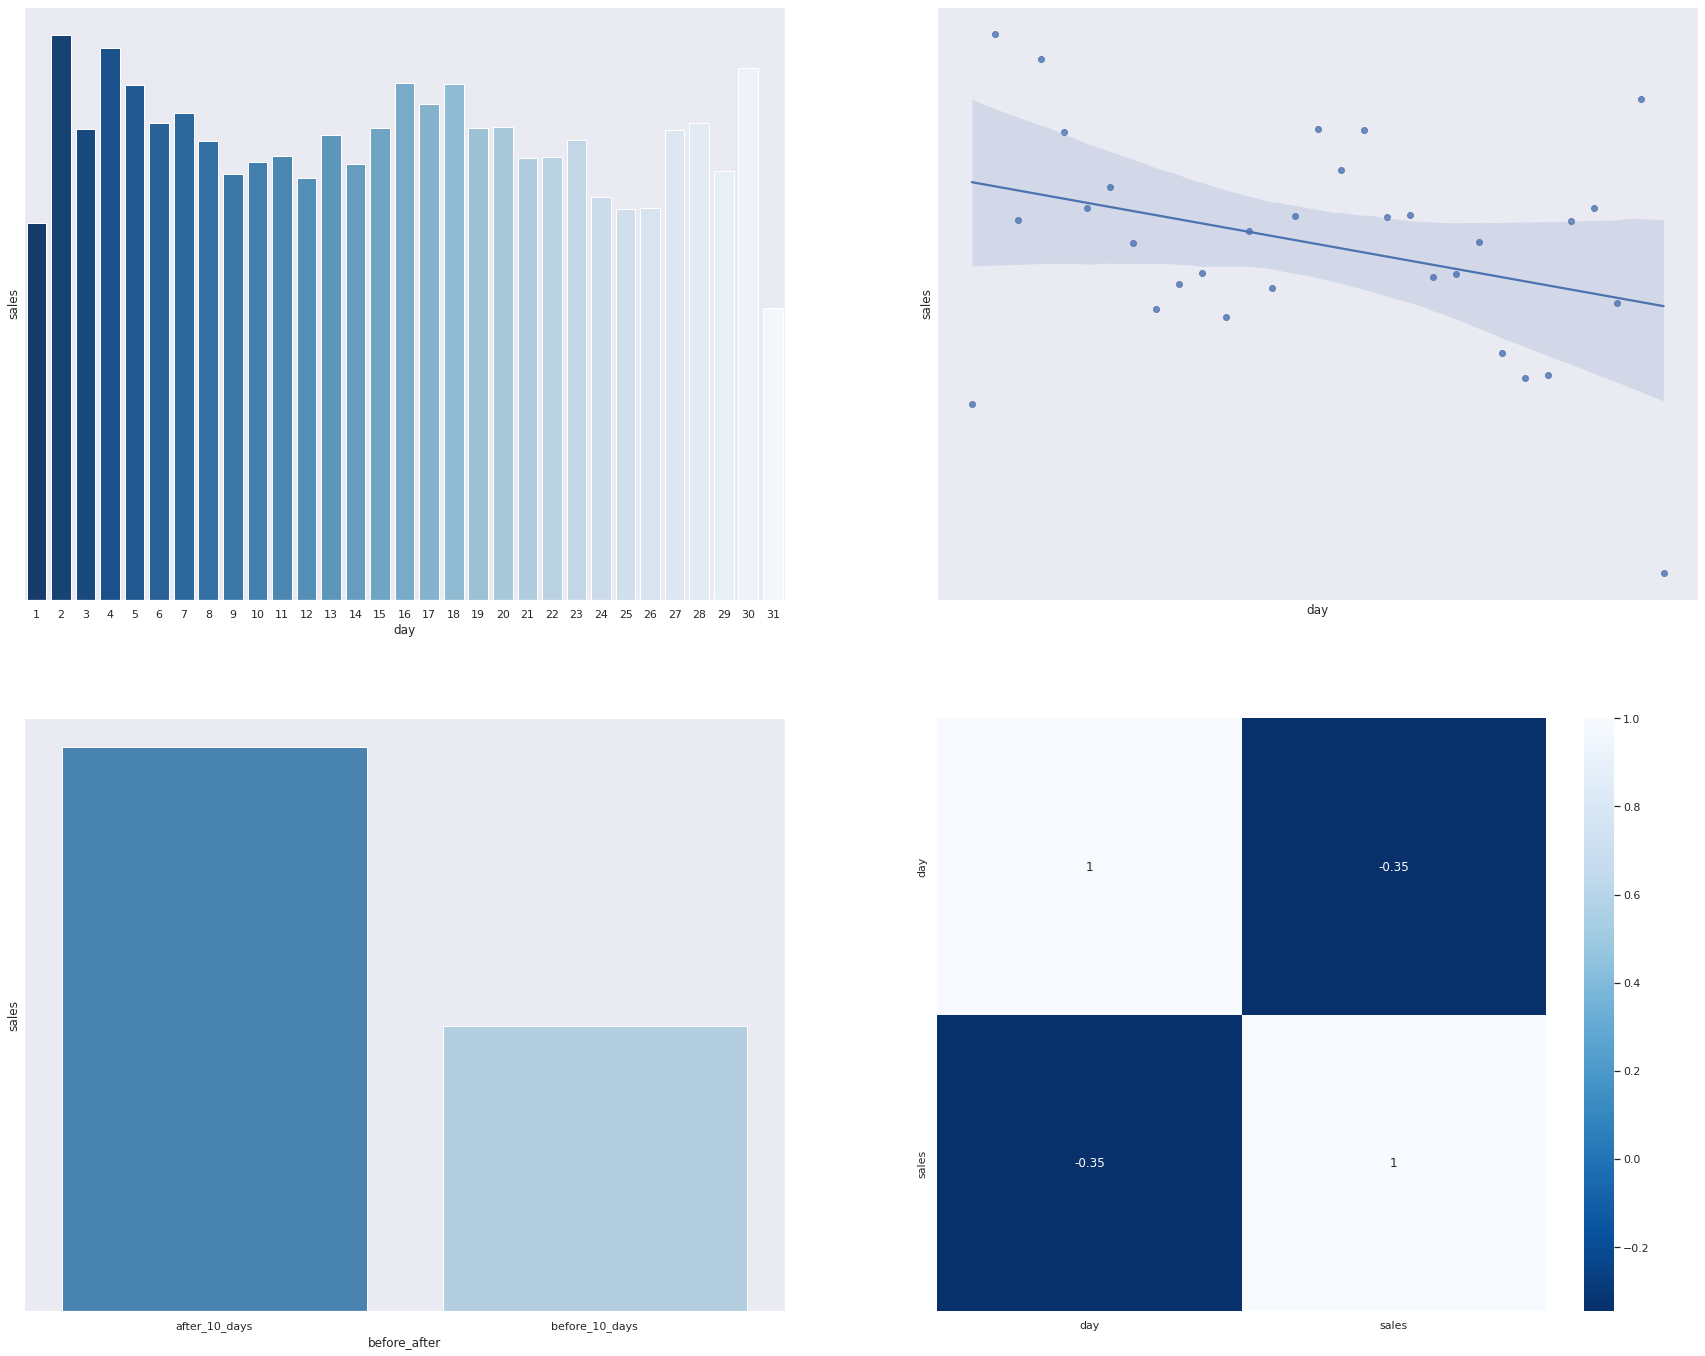

In [54]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=[30, 24])

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1, palette='Blues_r');
plt.yticks([],[])

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);
plt.yticks([],[])
plt.xticks([],[])


plt.subplot(2,2,4)
sns.heatmap(aux1.corr(method='pearson'), annot=True, data=aux1, cmap='Blues_r');

plt.subplot(2,2,3)
aux1['before_after'] =  aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2, palette='Blues_r')
plt.yticks([],[])

plt.savefig('../img/h12', dpi=300, bbox_inches='tight')

In [55]:
!pip install tabulate
tab = [['Hipotese', 'Conclusão', 'Relevancia'], 
        ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'MEDIA'],
      ['H3', 'Falsa', 'média'],
      ['H4', 'Falsa', 'Média'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Média'],
      ['H9', 'Falsa', 'alta'],
      ['H10', 'Falsa', 'alta'],
      ['H11', 'Verdadeira', 'alta'],
      ['H12', 'Verdadeira', 'alta'],
      ['H13', 'Verdadeira', 'Baixa']]
from tabulate import tabulate
print(tabulate(tab, headers='firstrow'))

Hipotese    Conclusão    Relevancia
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        MEDIA
H3          Falsa        média
H4          Falsa        Média
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Baixa
H8          Falsa        Média
H9          Falsa        alta
H10         Falsa        alta
H11         Verdadeira   alta
H12         Verdadeira   alta
H13         Verdadeira   Baixa


## Analise Multivariada

## Numerical numerical relation

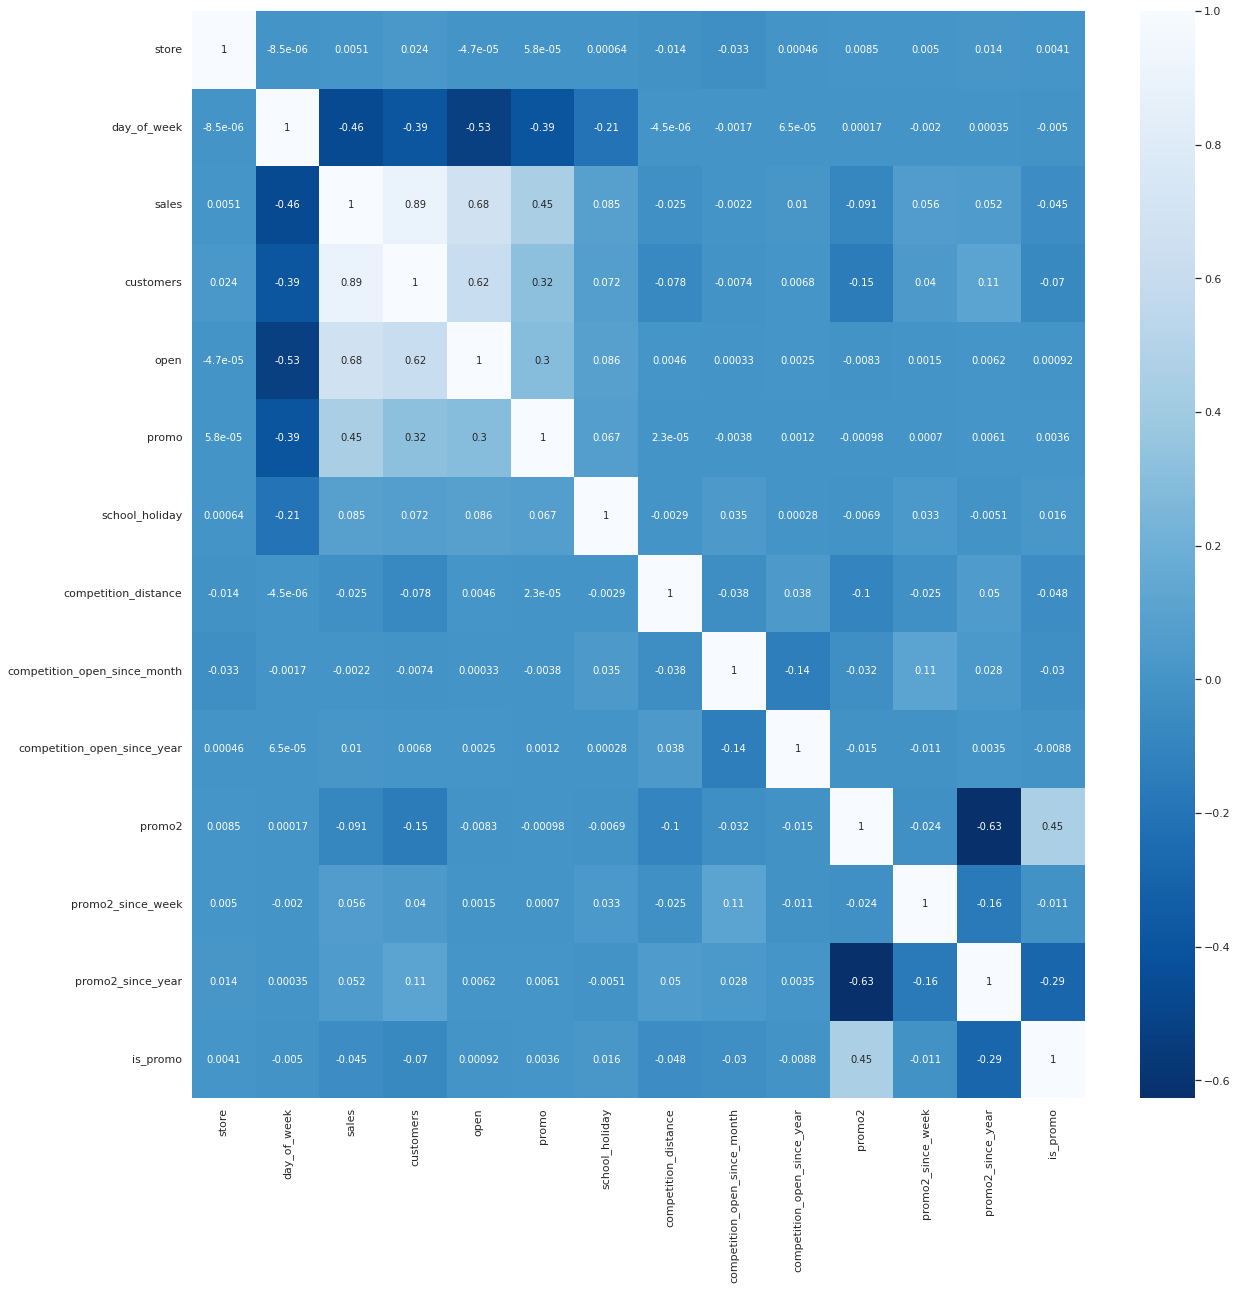

In [104]:
plt.figure(figsize=(20,20))

correlation = num_attributes.corr(method='pearson')

sns.heatmap(correlation, annot=True, cmap='Blues_r');

plt.savefig('../img/multivariate_num.png', dpi=300, bbox_inches='tight')


## Categorical multivariate relationship

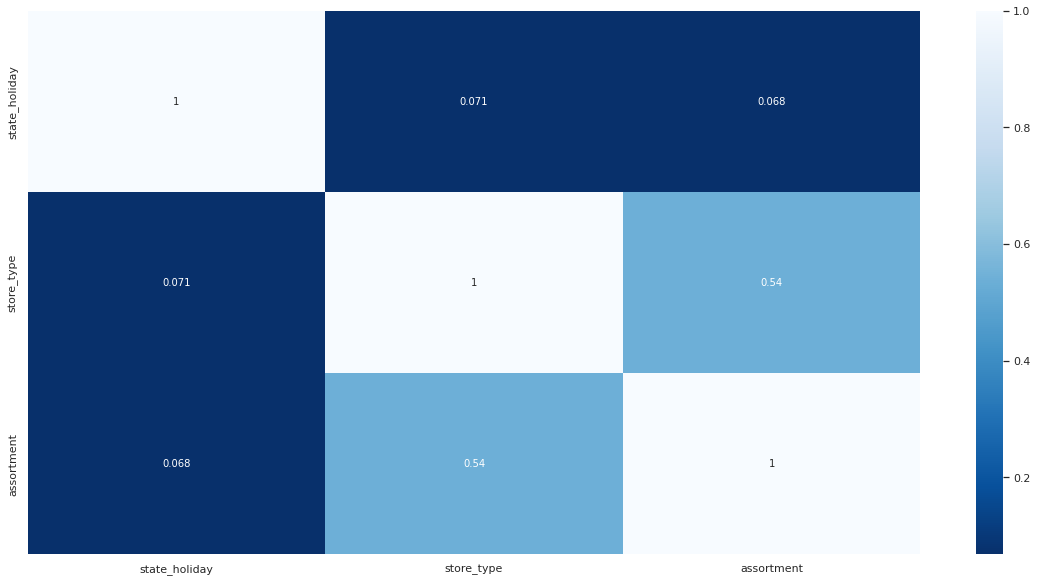

In [105]:
#apenas categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

plt.figure(figsize=(20,10))
sns.heatmap(d, annot=True, cmap='Blues_r');

plt.savefig('../img/multivariate_cat.png', dpi=300, bbox_inches='tight')


**Correlação forte entre assortment e store_type**

# Modelagem dos dados

## Normalização


In [56]:
df5 = df4.copy()
data_cutted = df5.select_dtypes(include=['int64', 'float64'])
data_cutted.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


## Rescaling

- > min-max scalar
- > robust scaler  

In [57]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

/home/jan/miniconda3/envs/ds_prod/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jan/miniconda3/envs/ds_prod/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jan/miniconda3/envs/ds_prod/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

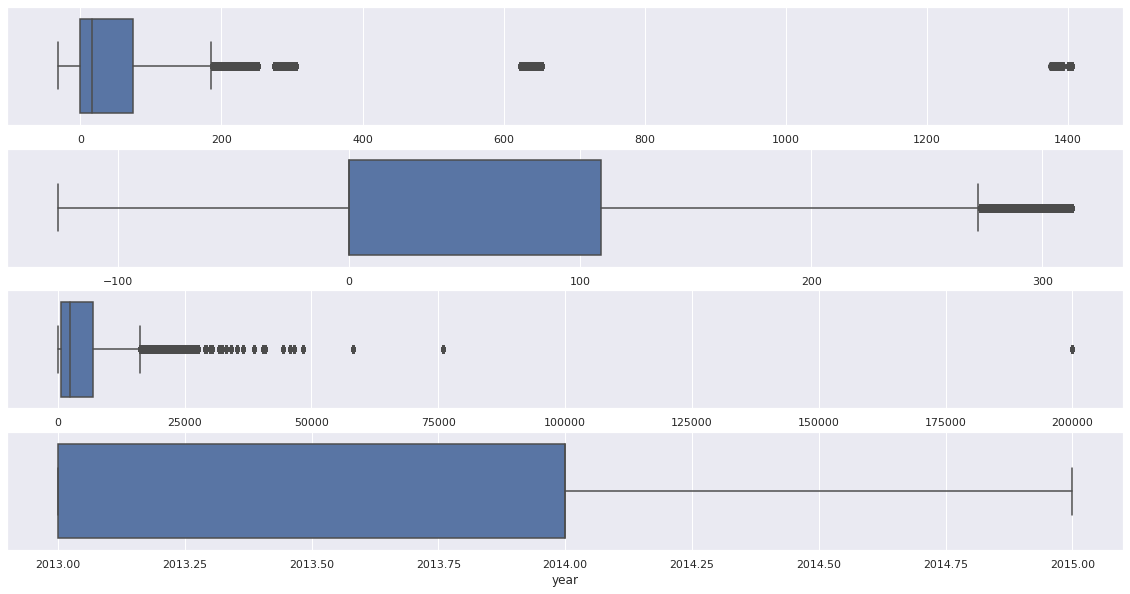

In [58]:
#checando se os outliers são valores expressivos dentro das colunas selecionadas. 

plt.figure(figsize=[20,10]);

plt.subplot(4,1,1)
sns.boxplot(df5['competition_time_month']);

plt.subplot(4,1,2)
sns.boxplot(df5['promo_time_week']);

plt.subplot(4,1,3)
sns.boxplot(df5['competition_distance']);

plt.subplot(4,1,4)
sns.boxplot(df5['year']);

In [59]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition 
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month 
df5.competition_time_month = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)


/home/jan/miniconda3/envs/ds_prod/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

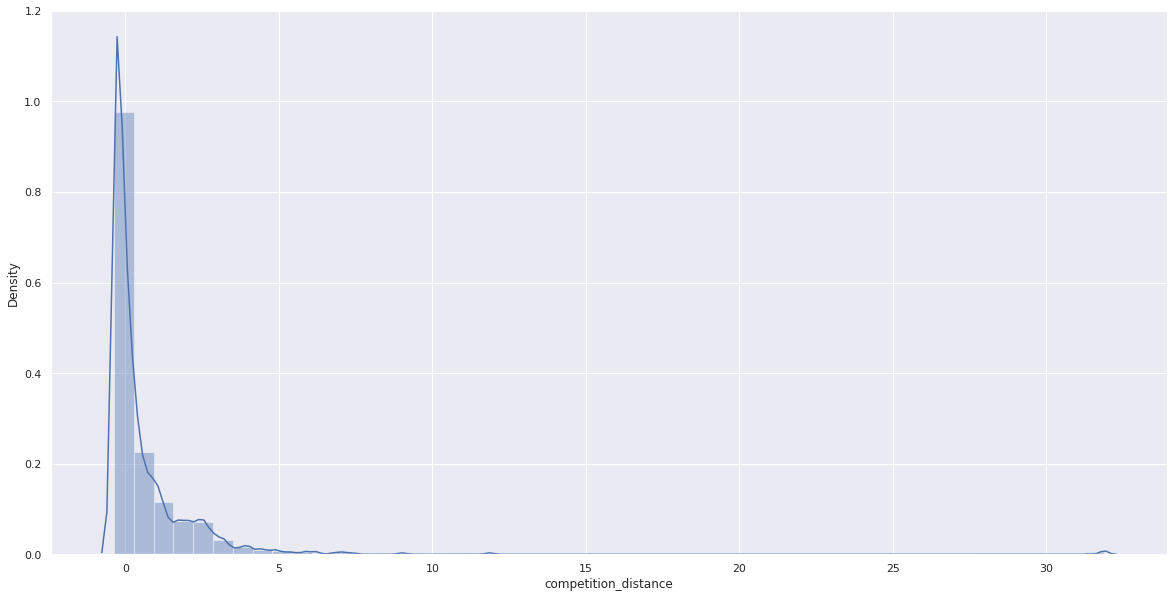

In [60]:
plt.figure(figsize=[20,10])

sns.distplot(df5['competition_distance'])

## tipos de encoding


- > One hot encoding
- > Label Encoding
- > Ordinal Encoding
- > target encoding
- > frequency encoding
- > Embedding Encoding

In [61]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [62]:
# state_holiday -> One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns=['state_holiday'])

#-----------------------------------

#store_type     -> label encoding
le = LabelEncoder()
df5.store_type = le.fit_transform(df5.store_type)

#-----------------------------------

#assortment    -> ordinal encoding
assortment_dict = {'basic':1,
                   'extra': 2,
                   'extended': 3}
df5.assortment = df5.assortment.map(assortment_dict)



## Transformação

- > Logarithm transformation
- > Box-Cox transformation
- > Cube-Root Transformation 
- > Square-Root Transformation
- > Sine and Cosine transformation


### Response variable transformation

/home/jan/miniconda3/envs/ds_prod/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


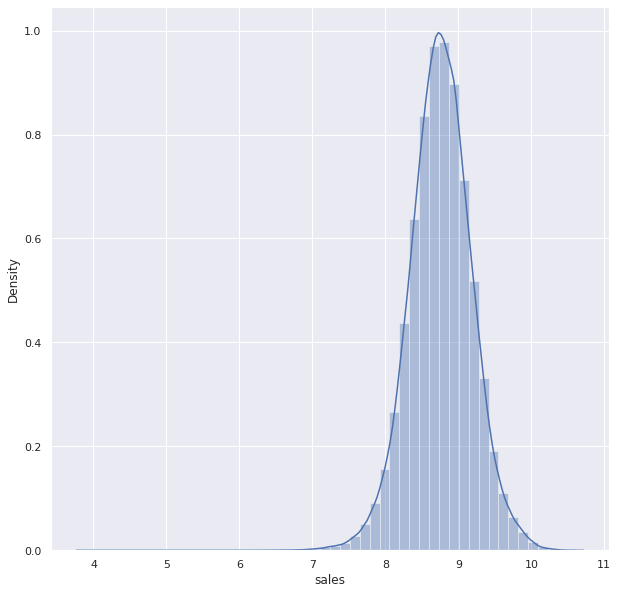

In [63]:
df5.sales = np.log1p(df5.sales)
#___________________________
plt.figure(figsize=[10,10])
sns.distplot(df5.sales);


### Transformação de natureza cíclica

In [64]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin (x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos (x * (2 * np.pi/7)))

#------------------------------------------------------------------------

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin (x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos (x * (2 * np.pi/12)))

#------------------------------------------------------------------------

#week_of_year
df5['week_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin (x * (2 * np.pi/52)))
df5['week_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos (x * (2 * np.pi/52)))

#------------------------------------------------------------------------

#Day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin (x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos (x * (2 * np.pi/30)))

#------------------------------------------------------------------------

df5

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_Public holiday,state_holiday_Regular day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_year_sin,week_year_cos,day_sin,day_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,8.124447,0,1,1,1,-0.351613,9,...,1,0,0.974928,-0.222521,0.5,0.866025,0.120537,0.992709,0.207912,0.978148
1016827,733,2,2013-01-01,9.284148,0,1,1,2,-0.237097,10,...,1,0,0.974928,-0.222521,0.5,0.866025,0.120537,0.992709,0.207912,0.978148
1016863,769,2,2013-01-01,8.524367,0,1,1,2,-0.240323,1,...,1,0,0.974928,-0.222521,0.5,0.866025,0.120537,0.992709,0.207912,0.978148
1017042,948,2,2013-01-01,8.410053,0,1,1,2,-0.145161,1,...,1,0,0.974928,-0.222521,0.5,0.866025,0.120537,0.992709,0.207912,0.978148


## Seleção de variáveis 

* Seleção Univariada - Filter Method
* Seleção por importancia - Embedded Methods
* Seleção por SubSet - Wrapper Methods

Boruta as feature selector
----------



In [65]:
df6 = df5.copy()

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

In [ ]:
df6 = df6.drop(cols_drop, axis=1)

In [ ]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

In [ ]:
#training dataset
X_train = df6[df6['date'] <= '2015-06-19']
y_train = X_train.sales

#testing dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test.sales

print(f'Training Min Date: {X_train.date.min()}')
print(f'Training Max Date: {X_train.date.max()}')
print()
print(f'Testin Min Date: {X_test.date.min()}')
print(f'Testing Max Date: {X_test.date.max()}')

              

In [ ]:
#implementação do boruta
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr       = RandomForestRegressor()

# ------------------------------ #
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()
# ------------------------------ #
boruta    = BorutaPy(rfr, 
                     n_estimators='auto', 
                     verbose=2, 
                     random_state=42).fit(X_train_n, y_train_n)

In [ ]:
## manual feature selection

selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin','month_cos', 'day_cos', 'week_year_sin', 'week_year_cos']

feat_to_add = ['sales', 'date']

selected_boruta.extend(feat_to_add)

